In [187]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import random
import circuitsvis as cv
from fancy_einsum import einsum

In [174]:
# model parameter constants
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 32
D_HEAD = 32
D_MLP = None
D_VOCAB = 12
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = torch.device("mps")

In [175]:
MAX_DIGITS = 5
NUM_DIGITS = 2
# 10 is between numbers, 11 for filler space
CTX_LEN = NUM_DIGITS * MAX_DIGITS + 1

In [176]:
def generate_number_with_variable_length(max_digits):
    num_digits = random.randint(1, max_digits)
    if num_digits == 1:
        return random.randint(0, 9)  # For a single digit, range is 0-9
    else:
        return random.randint(10**(num_digits-1), 10**num_digits - 1)

def generate_data(n, training=True):
    tokens = []
    target = []

    for _ in range(n):
        curr = []
        answer = ""
        
        a = (generate_number_with_variable_length(MAX_DIGITS))
        b = (generate_number_with_variable_length(MAX_DIGITS))

        if a > b:
            answer = "a"
        else:
            answer = "b"

        i = 0
        for digit in str(a):
            curr.append(int(digit))
            i += 1
        while i < MAX_DIGITS:
            curr.append(11)
            i += 1
        
        curr.append(10)
        
        i = 0
        for digit in str(b):
            curr.append(int(digit))
            i += 1
        while i < MAX_DIGITS:
            curr.append(11)
            i += 1
        
        if answer == "a":
            answer_list = curr[:MAX_DIGITS]
        else:
            answer_list = curr[MAX_DIGITS+1:]

        # answer_list = curr[MAX_DIGITS + 1:]

        # while len(answer_list) < CTX_LEN:
        #     answer_list.append(11)
            
        tokens.append(curr)
        target.append(answer_list)

    return torch.tensor(tokens), torch.tensor(target)

generate_data(10)

(tensor([[ 6,  7,  1, 11, 11, 10,  5,  3,  4,  1,  6],
         [ 3, 11, 11, 11, 11, 10,  4,  6, 11, 11, 11],
         [ 5,  9, 11, 11, 11, 10,  1,  6,  5,  7,  1],
         [ 7,  7,  8,  3,  0, 10,  8,  5,  1,  3,  7],
         [ 4,  8,  5, 11, 11, 10,  7,  5,  8,  3,  4],
         [ 2, 11, 11, 11, 11, 10,  5,  3, 11, 11, 11],
         [ 6,  6,  6, 11, 11, 10,  1,  7,  9, 11, 11],
         [ 5,  8, 11, 11, 11, 10,  8,  1,  6,  0, 11],
         [ 8,  2,  6, 11, 11, 10,  7,  0,  2,  5, 11],
         [ 1,  9,  1,  8, 11, 10,  2,  3,  6,  6, 11]]),
 tensor([[ 5,  3,  4,  1,  6],
         [ 4,  6, 11, 11, 11],
         [ 1,  6,  5,  7,  1],
         [ 8,  5,  1,  3,  7],
         [ 7,  5,  8,  3,  4],
         [ 5,  3, 11, 11, 11],
         [ 6,  6,  6, 11, 11],
         [ 8,  1,  6,  0, 11],
         [ 7,  0,  2,  5, 11],
         [ 2,  3,  6,  6, 11]]))

In [177]:
# model setup

# MIGHT HAVE TO CHANGE CONTEXT OR VOCAB
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=CTX_LEN,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)

# hooked transformer used for interpretation later
model = HookedTransformer(cfg, move_to_device=True)
# model.to(DEVICE)

In [178]:
def loss_function(logits, target, return_per_token=True, print_tokens=False):
    answer = target
    logits = logits[:, MAX_DIGITS + 1 : , :]
    log_prob = logits.log_softmax(-1)
    output_prob = log_prob.gather(-1, answer[..., None])[..., 0]

    # mask = (target != 11).float()
    # masked_output_prob = output_prob * mask

    if print_tokens:
        print("target", target)
        print("predicted", torch.argmax(logits, dim=-1))
        # print(answer.unsqueeze(-1))
        # print(output_prob)
        
    if return_per_token:
        # return -(masked_output_prob / mask.sum(dim=1, keepdim=True).clamp(min=1))
        return -output_prob
    # return -(masked_output_prob.sum() / mask.sum())
    return -output_prob.mean()

In [179]:
def accuracy(logits, target, return_per_token=False):
    logits = logits[:, MAX_DIGITS + 1:, :]
    predicted = torch.argmax(logits, dim=-1)
    answer = target
    # print(predicted, answer)
    if return_per_token:
        return (predicted == answer).float()
    return (predicted == answer).float().mean().item()

In [180]:
import torch
import torch.nn as nn
import numpy as np

def train_model(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    
    # Assuming you've defined your model's vocabulary size somewhere
    vocab_size = 12 # Adjust this based on your actual vocab size
    train_losses = []
    # model.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        for _ in range(batches_per):
            tokens, targets = generate_data(batch_size, training=True)  # Adjusted to expect tokens and targets
            logits = model(tokens)
            
            # print(tokens)
            losses = loss_function(logits, targets, print_tokens=False)
            
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses.extend(losses.detach())

        # epoch_losses_cpu = [loss.cpu().numpy() for loss in epoch_losses]
        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

    model.eval()

    test_data, targets = generate_data(1280, training=True)
    logits = model(test_data)

    acc = accuracy(logits, targets, return_per_token=False)

    print(f"Validation accuracy: {acc}")

    return train_losses


In [181]:
torch.set_printoptions(threshold=10000)
losses = train_model(model, 300, 128, 10)

Epoch 0, train loss: 2.2213776111602783
Epoch 10, train loss: 0.4503398835659027
Epoch 20, train loss: 0.3361239731311798
Epoch 30, train loss: 0.30249735713005066
Epoch 40, train loss: 0.2920592427253723
Epoch 50, train loss: 0.2780539393424988
Epoch 60, train loss: 0.28201010823249817
Epoch 70, train loss: 0.2729364335536957
Epoch 80, train loss: 0.26289260387420654
Epoch 90, train loss: 0.2572329342365265
Epoch 100, train loss: 0.26881974935531616
Epoch 110, train loss: 0.26019027829170227
Epoch 120, train loss: 0.24818964302539825
Epoch 130, train loss: 0.2536875903606415
Epoch 140, train loss: 0.24656520783901215
Epoch 150, train loss: 0.24911728501319885
Epoch 160, train loss: 0.24543923139572144
Epoch 170, train loss: 0.24649688601493835
Epoch 180, train loss: 0.24754108488559723
Epoch 190, train loss: 0.2517950236797333
Epoch 200, train loss: 0.2511204183101654
Epoch 210, train loss: 0.2570186257362366
Epoch 220, train loss: 0.23972007632255554
Epoch 230, train loss: 0.24159143

In [182]:
tokens, targets = generate_data(128, training=True)
logits, cache = model.run_with_cache(tokens)
attention_pattern = cache["pattern", 0, "attn"]

In [183]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [184]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [185]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [186]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

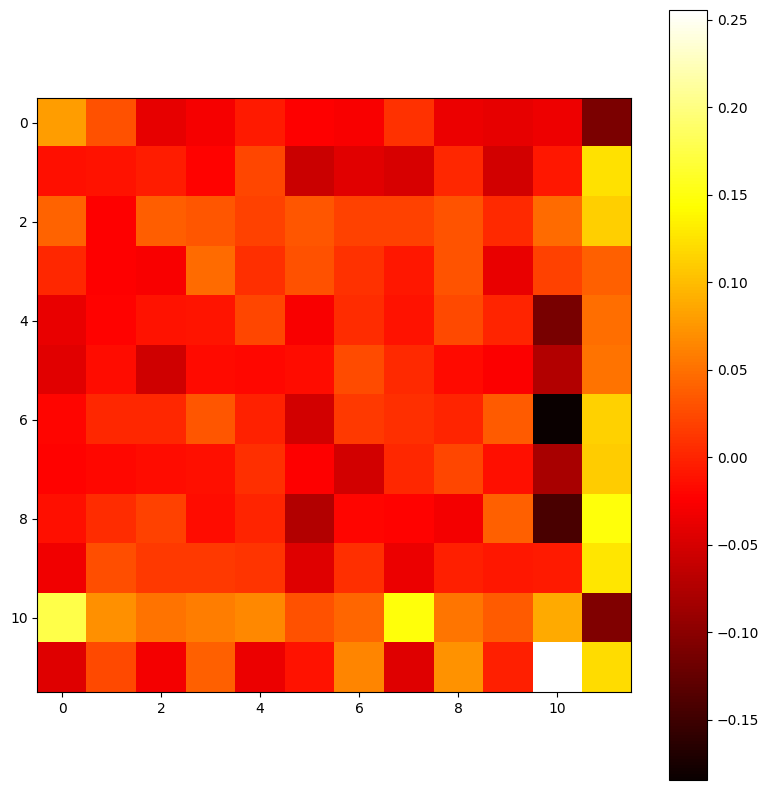

In [188]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()